# RNN for weather forecast

Task: predicting the temperature in Seattle over time, based on historical data.

In [1]:
import numpy as np
import pandas as pd
from skorch import NeuralNetRegressor
import torch
import torch.nn as nn
import torch.optim as optim

# Load dataset
df = pd.read_csv('data/rnn/seattle-weather.csv')

df.head()


,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [2]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [3]:
# count missing values
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [4]:
# count duplicates
df.duplicated().sum().item()

0

In [5]:
# temperature as training data
training_data = df["temp_max"].values.reshape(-1,1)
training_data

array([[12.8],
       [10.6],
       [11.7],
       ...,
       [ 7.2],
       [ 5.6],
       [ 5.6]], shape=(1461, 1))

In [6]:
# Build training set.
# Use a sliding window approach to create overlapping sequences of length window_size.
# For each sequence (window), it extracts:
# - X_train: The features, consisting of window_size consecutive values from the first column of df.
# - y_train: The target value, which is the next value (immediately after the window) in the first column of df.
def df_to_XY(df, window_size=20):
    X_train = np.array([df[i - window_size:i, 0] for i in range(window_size, len(df))])
    y_train = np.array([df[i, 0] for i in range(window_size, len(df))])
    return X_train, y_train

window_size = 20
X,y = df_to_XY(training_data, window_size)
print(len(X),len(y))

# split into training, validation and test (do not use shuffling)
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
y_test = y[1000:]

1441 1441


In [7]:
print(X_train.shape, y_train.shape)

(800, 20) (800,)


In [8]:
# Reshape data into num_samples x sequence_length x number of features per sample (only temp_max)
X_train = torch.tensor(np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)), dtype=torch.float32)
X_val = torch.tensor(np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1)), dtype=torch.float32)
X_test = torch.tensor(np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1)), dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
y_val = torch.tensor(y_val.reshape(-1,1), dtype=torch.float32)

In [9]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity="relu")
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Take the last output for prediction
        return out

In [10]:
input_size = X_train.shape[2]
hidden_size = 50
num_layers = 4
output_size = input_size

model = RNNModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)


In [12]:
from skorch.dataset import Dataset
from skorch.callbacks import EarlyStopping
from skorch.helper import predefined_split

valid_ds = Dataset(X_val, y_val)

net = NeuralNetRegressor(
    model,
    max_epochs=500,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    # specify a validation set instead of letting skorch choose it
    train_split=predefined_split(valid_ds),
    callbacks=[
    EarlyStopping(
        monitor='valid_loss',   # what metric to watch
        patience=100,             # stop after 5 epochs with no improvement
        load_best=True          # restore best model after stopping
    )
    ],
)

net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      275.1956      435.9860  0.1952
      2      130.9245      211.4067  0.0696
      3       49.9352       82.1784  0.0672
      4       24.8472       16.9698  0.0662
      5       14.2836       17.3032  0.0662
      6       12.8511       17.8290  0.0690
      7       12.0880       16.5324  0.0657
      8       11.9814       15.7768  0.0662
      9       11.6388       15.6917  0.0658
     10       11.4284       15.5920  0.0656
     11       11.1691       15.8306  0.0780
     12       11.0657       17.7238  0.0699
     13       11.5624       20.6922  0.0711
     14       12.5739       20.4628  0.0682
     15       12.6211       17.3871  0.0685
     16       11.5433       15.5661  0.0687
     17       10.4933       16.7315  0.0665
     18       10.7708       19.2635  0.0677
     19       11.3763       20.8936  0.0669
     20       12.2484       21.0822  0.0666
     21       12.2032       17.3

,module,"RNNModel( (..., bias=True) )"
,criterion,<class 'torch...loss.MSELoss'>
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.001
,max_epochs,500
,batch_size,64
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>
,train_split,functools.par... 0x15f739fa0>)
,callbacks,[<skorch.callb...t 0x15f416cf0>]


In [13]:
train_pred = net.predict(X_train).flatten()
val_pred = net.predict(X_val).flatten()
test_pred = net.predict(X_test).flatten()

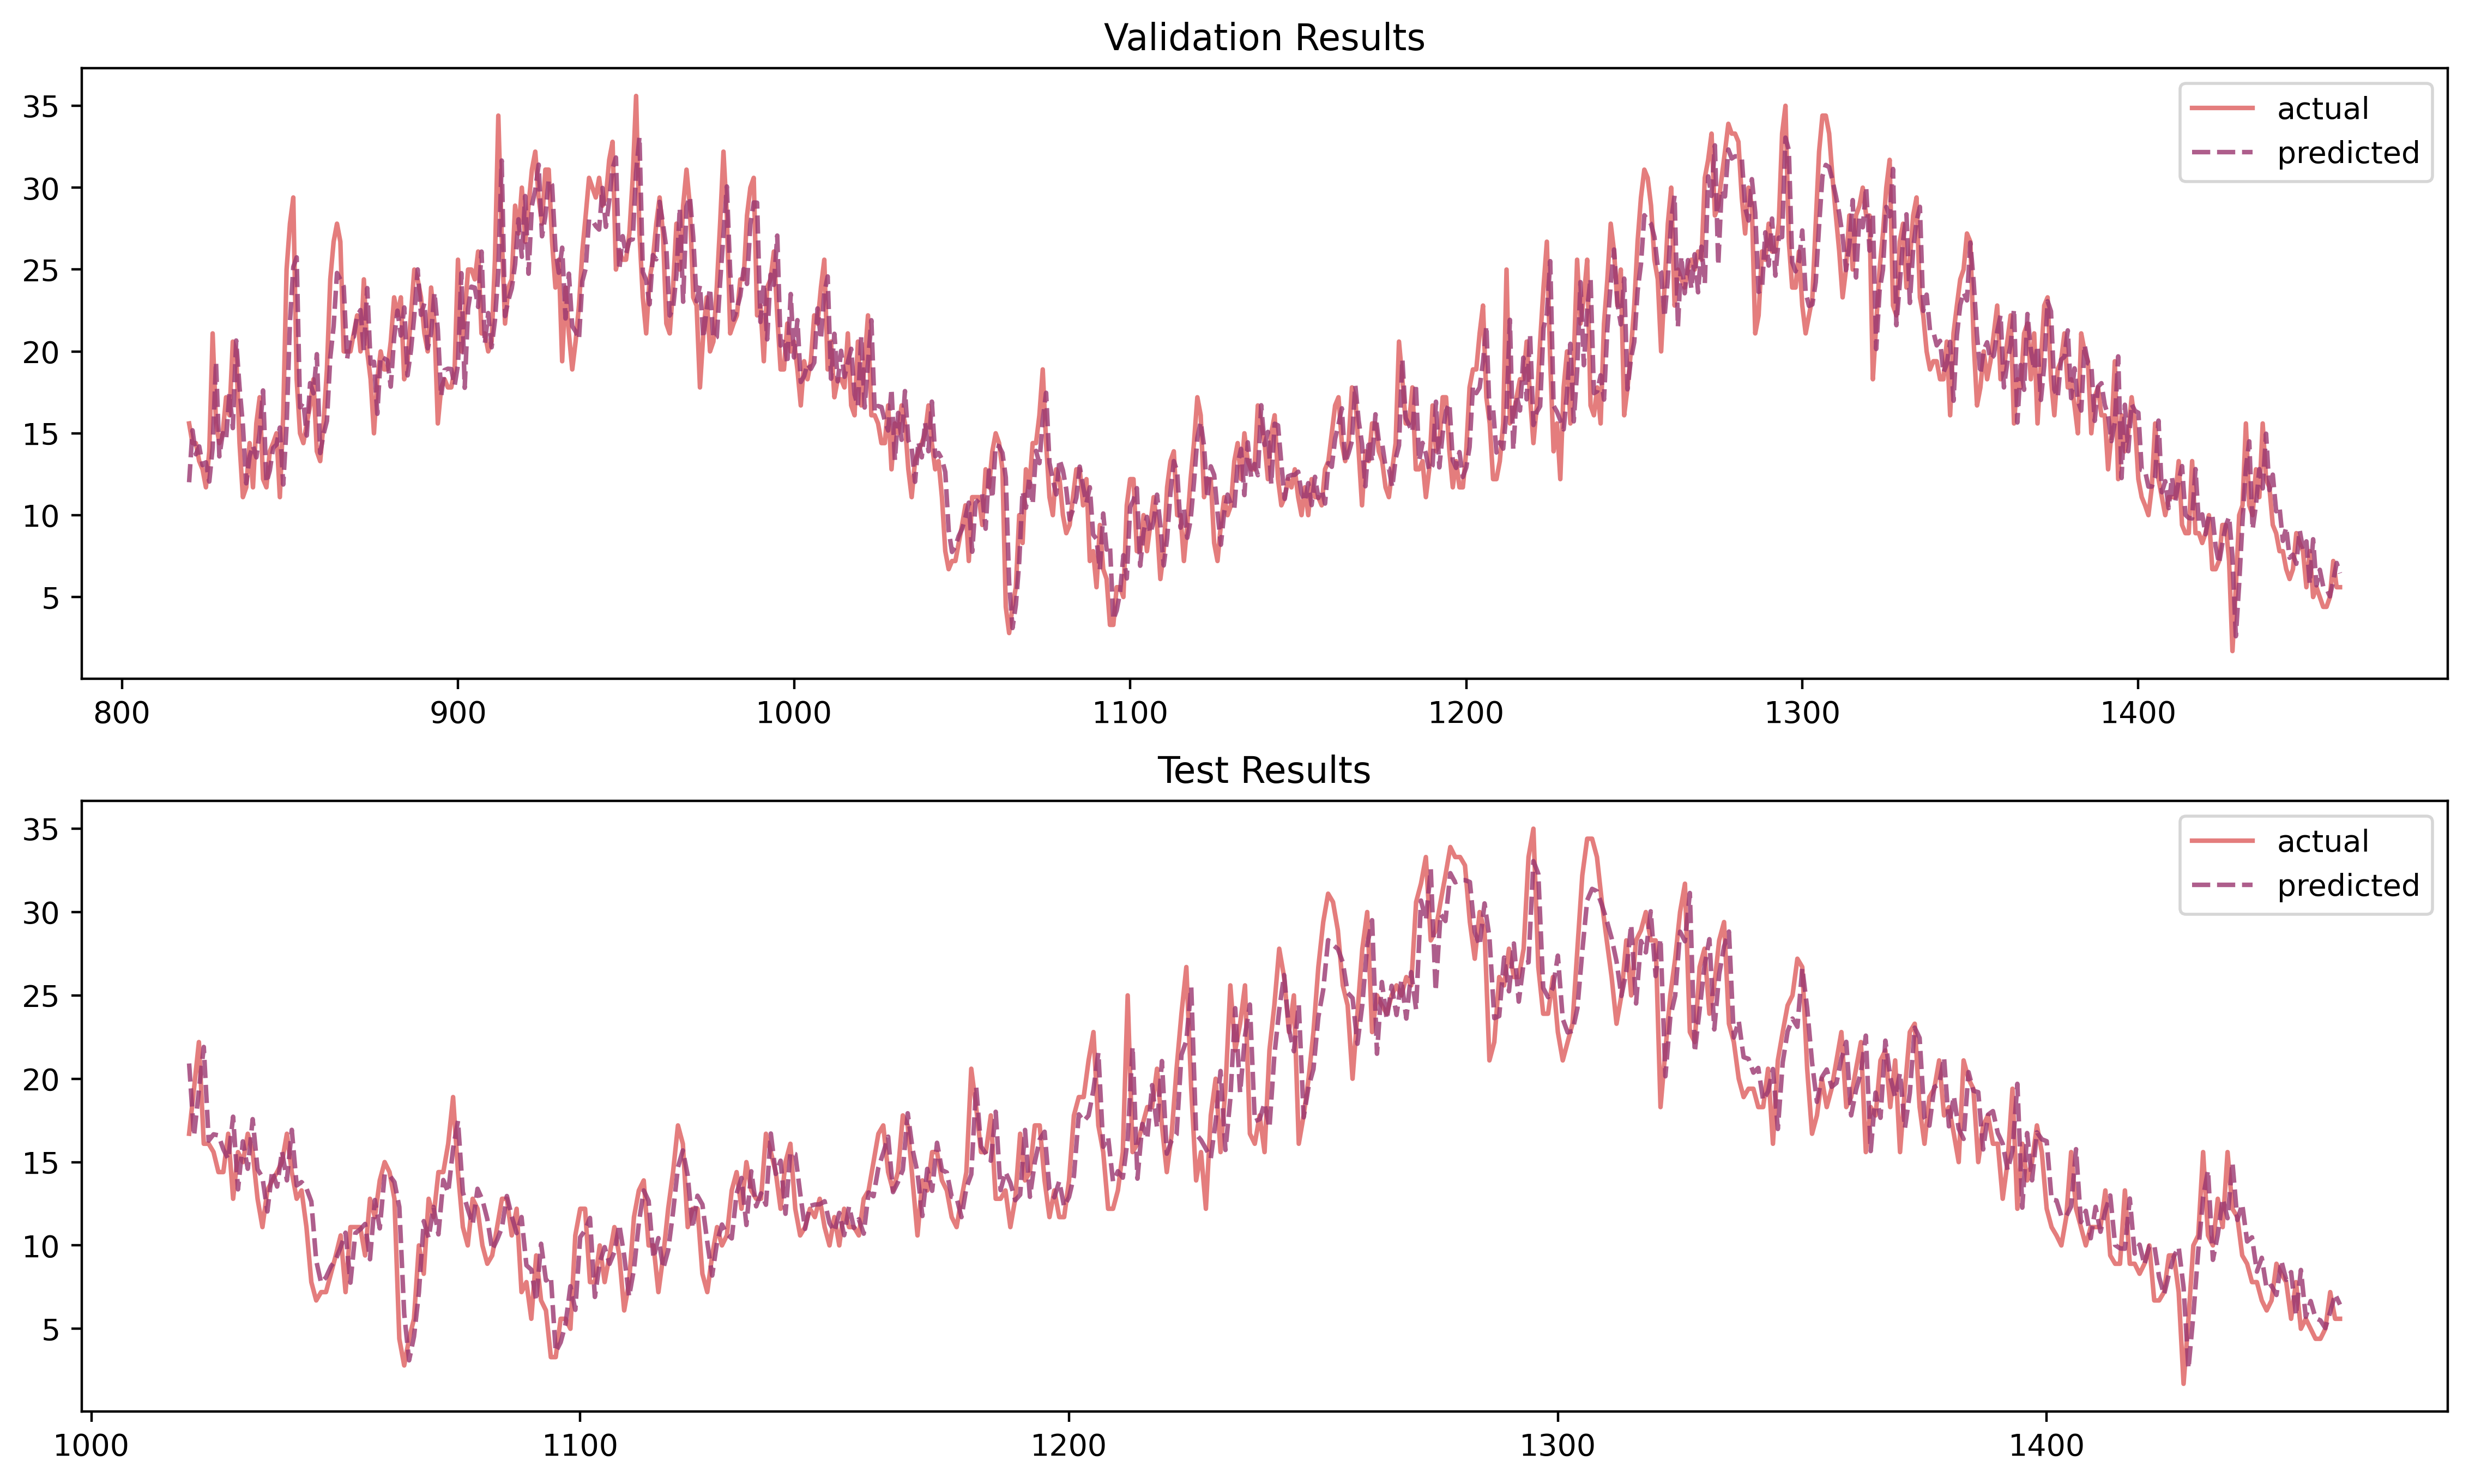

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[window_size:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:],alpha=0.8,palette="flare",linestyle=None);